In [13]:
import numpy as np
import pandas as pd
import csv

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

In [1]:
%load_ext autoreload
%autoreload 2
from main.viz.image_grids import imshow
from main.models.classification_layers import final_net
from main.interpretation.gradcam import ModelOutputs, FeatureExtractor, GradCam
from main.utils.loaders import FaceDataSetAlign as FaceDataSet

UsageError: Missing module name.


In [6]:
if torch.cuda.is_available():
    device_ = torch.device('cuda')
else:
    device_ = 'cpu'

# Set up model
weights_resnet = ResNet50_Weights.IMAGENET1K_V2
model_res = resnet50(weights=weights_resnet)

# Set up class layer
num_in = model_res.fc.out_features
last_layers = final_net(num_in=num_in)
model_res = model_res.to(device_)

last_layers = last_layers.to(device_)
model = nn.Sequential(model_res, last_layers)
model = model.to(device_)

model.load_state_dict(torch.load('./data/test_model.torch'))


<All keys matched successfully>

In [50]:
with open('data/raw/annotations/list_attr_celeba.txt') as csv_file:
            data = list(csv.reader(csv_file, delimiter=' ', skipinitialspace=True))

data_labs = pd.DataFrame(data[2:])
data_labs.columns = ['img_id'] + data[1][:-1]
data_labs.iloc[:,25] = np.where(data_labs.iloc[:,25] == '1', 1, 0)
data_labs.iloc[:,21] = np.where(data_labs.iloc[:,21] == '1', 1, 0)

# Run
preprocessor_ = weights_resnet.transforms()
train_ds = FaceDataSet(data_labs, sens_idx=21,transform=preprocessor_)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)


In [84]:
check_extractor = FeatureExtractor(model, ["layer4"])

# Overlay

In [14]:
data_labs = pd.read_csv('.data/prepared/faces/direct_faces.csv')

In [117]:
data_labs = pd.read_csv('./data/prepared/faces/direct_faces.csv')

#  Load model and prepare
weights_resnet = ResNet50_Weights.IMAGENET1K_V2
preprocessor_ = weights_resnet.transforms()

valid_dataset = FaceDataSet(data_labs, sens_idx=21,transform=preprocessor_)
validation_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [ ]:
if torch.cuda.is_available():
    device_ = torch.device('cuda')
else:
    device_ = 'cpu'

# Set up model
weights_resnet = ResNet50_Weights.IMAGENET1K_V2
model_res = resnet50(weights=weights_resnet)

# Set up class layer
num_in = model_res.fc.out_features
last_layers = final_net(num_in=num_in)
model_res = model_res.to(device_)

last_layers = last_layers.to(device_)
model = nn.Sequential(model_res, last_layers)
model = model.to(device_)

model.load_state_dict(torch.load('./data/test_model.torch'))


In [189]:
feat_list = []
out_list = []
tensors_out = []
for inputs, labels, _ in validation_dataloader:       
    inputs, labels = Variable(inputs.to(device_)), Variable(labels.to(device_)) 
    grad_cam = GradCam(model, target_layer_names = ["layer4"], use_cuda=False)
    out_ = grad_cam(inputs)

    feat_list.append(list(_.detach().numpy()))
    out_list.append(out_)
    tensors_out.append(inputs)

In [190]:
all_gradcams = {'sens': feat_list, 
                'out_tabs': out_list, 
                'img_tensors': tensors_out}

In [191]:
# with open('.data/prepared/all_gradcams.pkl', 'wb') as con_:
#     pickle.dump(all_gradcams, con_)

# Retrace

In [192]:
collapesed_features = [_[0] for _ in feat_list]
feature_mask = (np.array(collapesed_features) == 1.0)

In [193]:
feature_mask = (np.array(collapesed_features) == 1.0)

In [194]:
mean_list_1  = [out_list[i] for i in list(np.where(feature_mask)[0])]
mean_list_2  = [out_list[i] for i in list(np.where(~feature_mask)[0])]

mean_img_1 = sum(mean_list_1) / sum(feature_mask)
mean_img_2 = sum(mean_list_2) / (len(feature_mask)-sum(feature_mask))

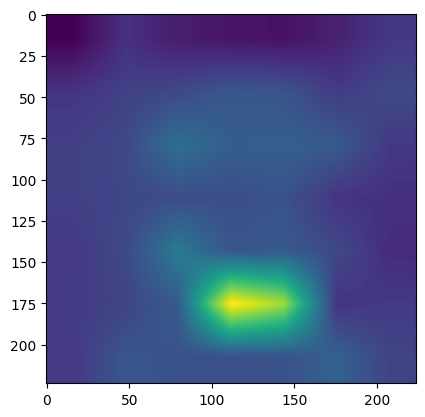

In [195]:
plt.imshow(mean_img_1)

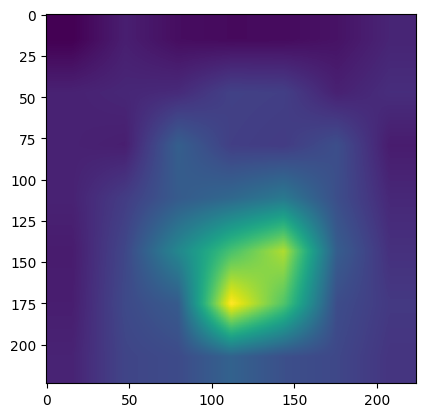

In [196]:
plt.imshow(mean_img_2)

In [203]:
mean_tensors_1 = [tensors_out[i] for i in list(np.where(feature_mask)[0])]
mean_tensors_2 = [tensors_out[i] for i in list(np.where(~feature_mask)[0])]

In [204]:
mean_1_torch = torch.mean(torch.cat(mean_tensors_1), 0)
mean_2_torch = torch.mean(torch.cat(mean_tensors_2), 0)

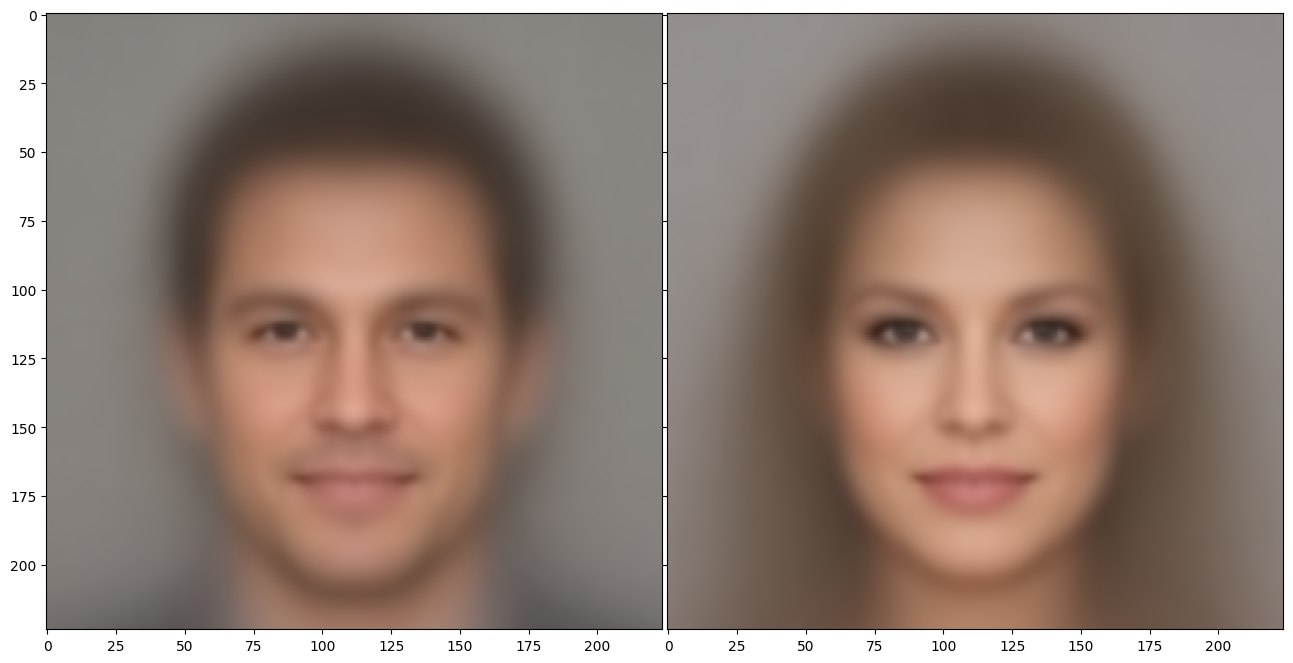

In [205]:
fig = plt.figure(1, figsize=(16, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)

imshow(grid[0], mean_1_torch)
imshow(grid[1], mean_2_torch)

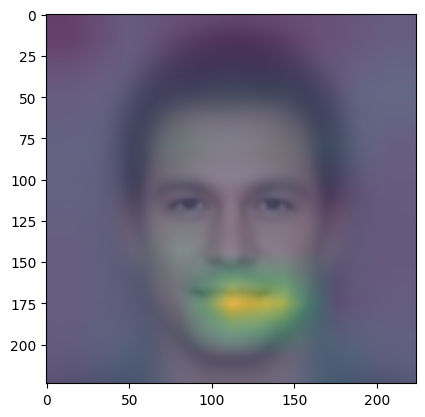

In [219]:
inp = mean_1_torch.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean

plt.imshow(inp)
plt.imshow(mean_img_1, alpha=0.5)

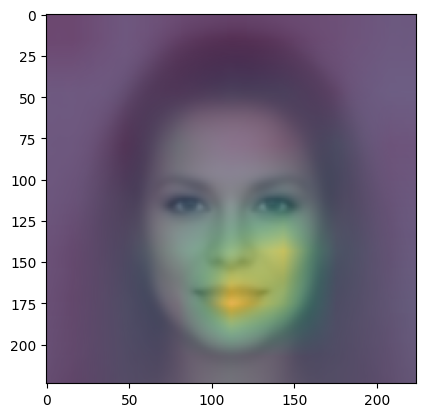

In [220]:
inp = mean_2_torch.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean

plt.imshow(inp)
plt.imshow(mean_img_2, alpha=0.5)

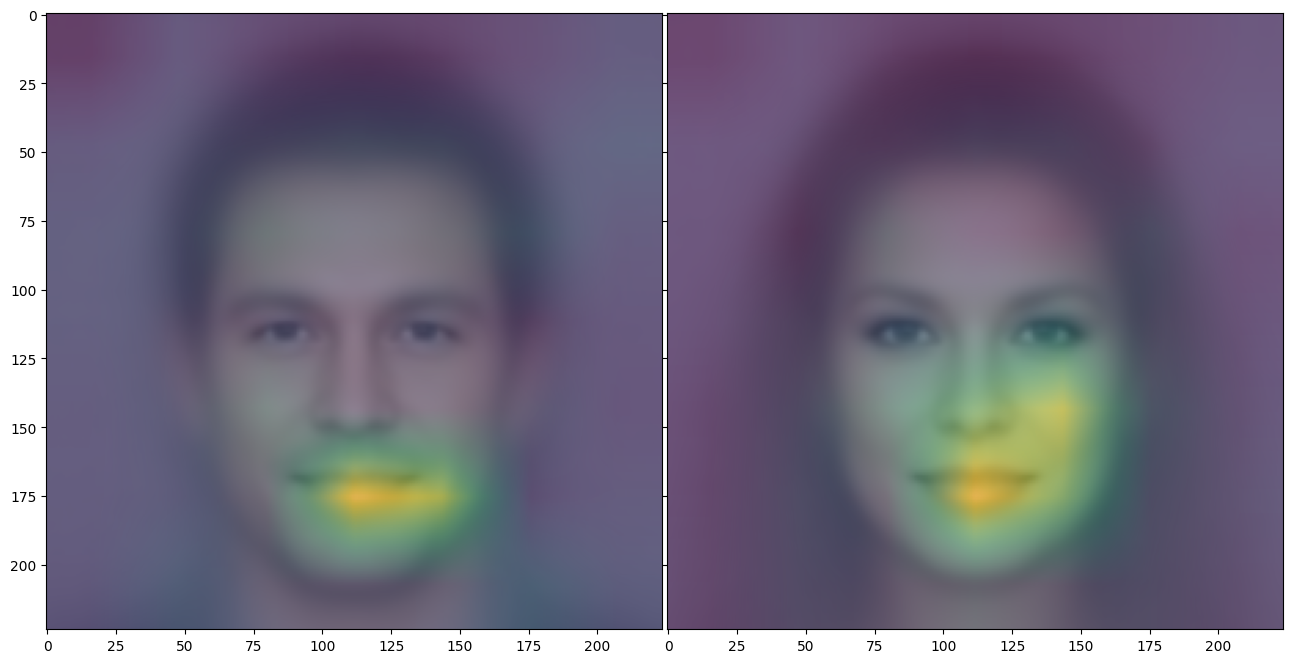

In [223]:
fig = plt.figure(1, figsize=(16, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)


inp = mean_1_torch.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean

grid[0].imshow(inp)
grid[0].imshow(mean_img_1, alpha=0.5)

inp = mean_2_torch.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean

grid[1].imshow(inp)
grid[1].imshow(mean_img_2, alpha=0.5)